# 3. Luther – Regression

## Imports & Versions

In [537]:
import numpy as np
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.externals import joblib
# joblib.dump(lr, 'data/survey_sk_model.pkl')
import statsmodels.api as sm
import statsmodels.formula.api as smf

% matplotlib inline

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import os
# chromedriver = "/Applications/chromedriver"
# os.environ["webdriver.chrome.driver"] = chromedriver

In [190]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
#                    ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

Numpy: 1.12.1
Pandas: 0.20.1
Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [195]:
with open('../data/AAL_clean.pkl', 'rb') as pf: 
    AAL = pickle.load(pf)

## What to Include and How...

In [196]:
AAL.describe()

,lateness_land,lateness_arr,taxi_act,taxi_sch,hour_of_day,q_of_day,weekday
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,6.978588,-10.851273,16.483796,34.313657,14.469329,1.980324,2.811921
std,29.797776,20.015784,8.062996,20.990499,4.362708,0.769772,1.967288
min,-45.000000,-58.000000,0.000000,0.000000,8.000000,1.000000,0.000000
25%,-19.000000,-25.000000,11.000000,13.000000,11.000000,1.000000,1.000000
50%,7.000000,-14.000000,16.000000,37.000000,14.000000,2.000000,3.000000
75%,27.000000,0.000000,19.000000,55.000000,18.000000,3.000000,4.000000
max,100.000000,51.000000,68.000000,77.000000,23.000000,3.000000,6.000000


Next, I'll split off the target column and possible feature columns.

In [356]:
AAL_sub = AAL.filter(['lateness_arr', 'taxi_sch', 'weekday', 'hour_of_day', 'q_of_day', 'f_num'])

...then inspect with corr / pair plot.

In [357]:
AAL_sub.corr()

,lateness_arr,taxi_sch,weekday,hour_of_day,q_of_day
lateness_arr,1.000000,0.098755,-0.143928,0.035127,0.042018
taxi_sch,0.098755,1.000000,-0.042011,-0.029291,-0.014167
weekday,-0.143928,-0.042011,1.000000,-0.023442,-0.031122
hour_of_day,0.035127,-0.029291,-0.023442,1.000000,0.933651
q_of_day,0.042018,-0.014167,-0.031122,0.933651,1.000000


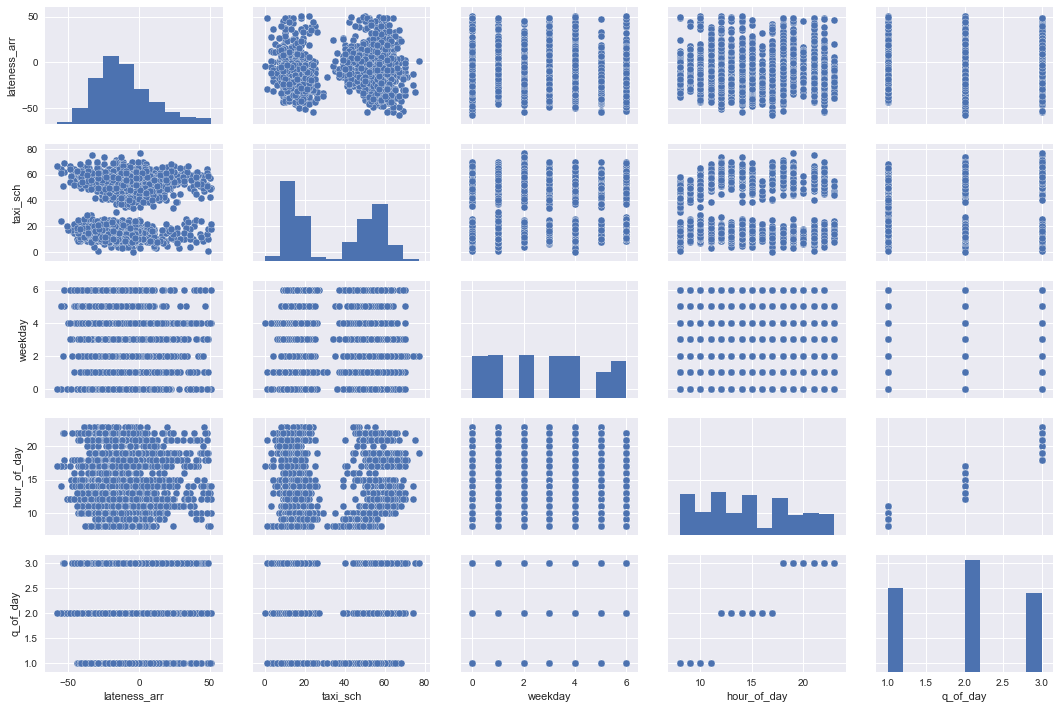

In [358]:
sns.pairplot(AAL_sub, size=2, aspect=1.5);

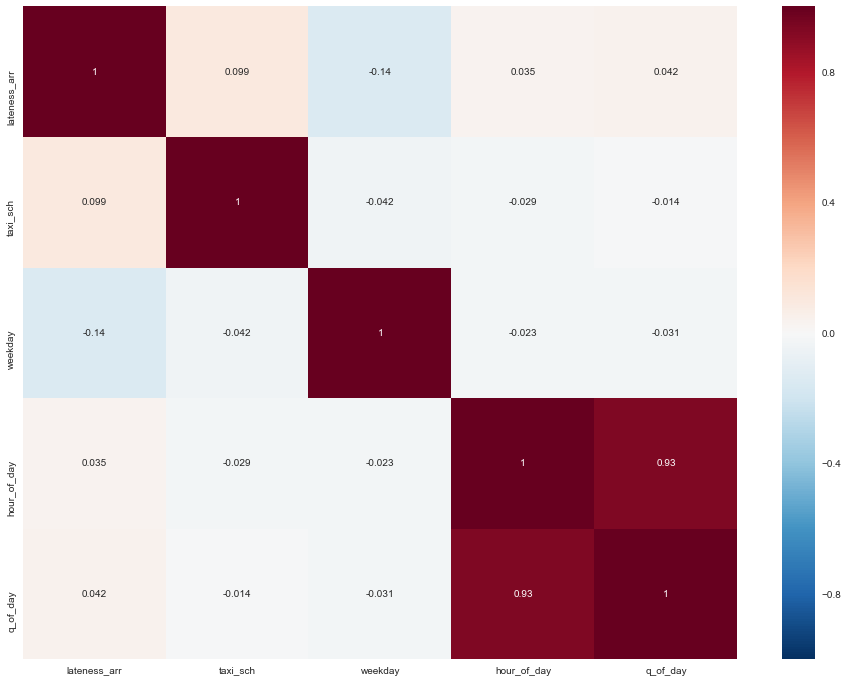

In [359]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_sub.corr(), annot=True)

Very weak correlation spotted with **weekday** and **lateness_arr**. Colinearity found with **hour_of_day** and **q_of_day** is not surprising, as the former is a roughly a subset of the latter. Thus, it would be best to use one or the other when modeling.

Now, convert categorical vars to dummy cols. Two sets to start with:

In [482]:
AAL_sub_twqf = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
          'f_num'
         ])
           )

In [483]:
AAL_sub_twh = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

In [484]:
AAL_twqf = (pd
            .get_dummies(AAL_sub_twqf, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [485]:
AAL_twh = (pd
            .get_dummies(AAL_sub_twh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [487]:
AAL_twqf.columns

Index(['lateness_arr', 'taxi_sch', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'q_of_day_2', 'q_of_day_3',
       'f_num_AAL187', 'f_num_AAL289', 'f_num_AAL304', 'f_num_AAL321',
       'f_num_AAL328', 'f_num_AAL332', 'f_num_AAL337', 'f_num_AAL343',
       'f_num_AAL345', 'f_num_AAL358', 'f_num_AAL359', 'f_num_AAL361',
       'f_num_AAL371', 'f_num_AAL373', 'f_num_AAL383', 'f_num_AAL390'],
      dtype='object')

In [488]:
AAL_twh.columns

Index(['lateness_arr', 'taxi_sch', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_of_day_9',
       'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13',
       'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17',
       'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21',
       'hour_of_day_22', 'hour_of_day_23'],
      dtype='object')

In [267]:
AAL.q_of_day.value_counts()

2    704
1    529
3    495
Name: q_of_day, dtype: int64

Since there are no flights scheduled to land between midnight and 6am, there are no zeros for the q_of_day (quarter of day) column, and thus only two dummies for that column. All others appear as expected.

#### Heat Map of Scheduled Taxi Time, Weekday, Quarter of Day, Flight Number

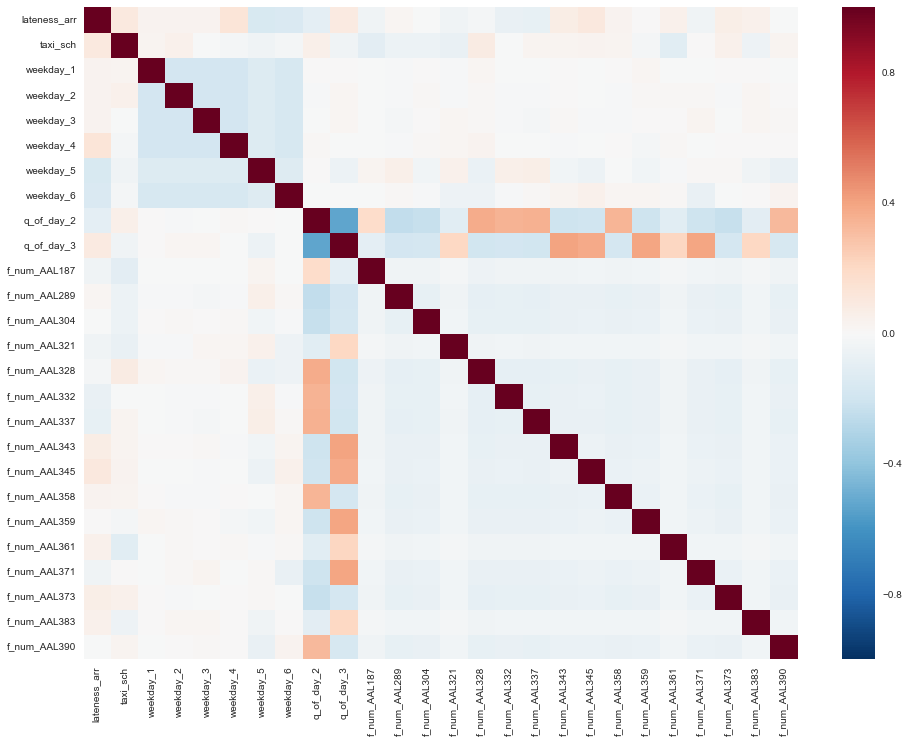

In [489]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_twqf.corr());

Not surprising that flight numbers show some correlation to the quarter of day in which they fall, which would be even more pronounced with hour of day. I'm suspecting that having both features in the model won't result in superior performance (perhaps a better MSE and larger R<sup>2</sup> value, but R<sup>2</sup>adj would suffer — we will test this).

#### Heat Map of Scheduled Taxi Time, Weekday, Hour of Day

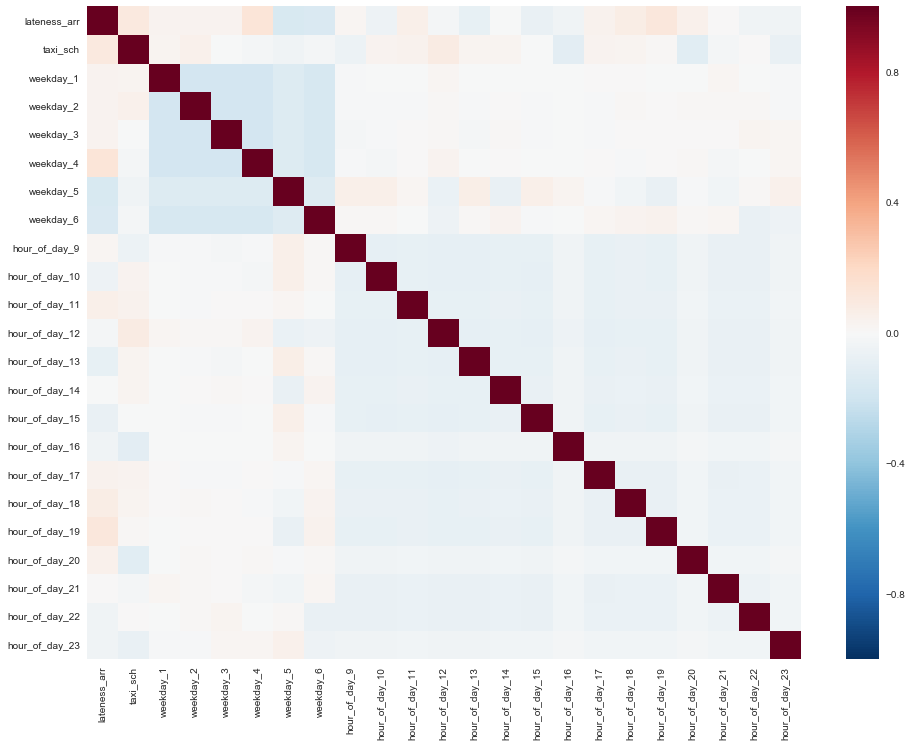

In [490]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_twh.corr());

## Let's Get To Regression

I should wrap this all into a class before Friday... HAHAHAHAHAHAHA!!!

In [461]:
def quick_lr(X, y, random_state=23):
    """
    Test/Train splits at 20/80, fits a LR to all features in X_train,
    then predicts based on X_test.
    """
    lr = LinearRegression()
    X_tr, X_ts, y_tr, y_ts = tts(X, y, test_size=0.20, random_state=random_state)
    lr.fit(X_tr, y_tr)
    y_hat = lr.predict(X_ts)
    
    MSE = mean_squared_error(y_ts, y_hat)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_ts, y_hat)
    r2 = lr.score(X_ts, y_ts)
    ar2 = adj_r2(r2, X_ts.shape[0], X_ts.shape[1])
                              
    print("R-squared (full):", lr.score(X, y))
    print("R-squared (test):", r2)
    print("Adj R-Squared (test):", ar2)
    # print("MSE:", MSE)
    print("RMSE:", RMSE)
    print("MAE:", MAE)
    
    return y_hat, y_ts

In [462]:
def adj_r2(rsquare, num_data, num_features):
    temp = (1-rsquare)*(num_data-1)
    temp = temp/(num_data-num_features-1)
    temp = 1 - temp
    return temp

In [463]:
def quick_yvy_scatter(ys):
    """
    Quick/dirty scatterplot of predicted v. real targets.
    """
    y_hat, y_act = ys
    plt.figure(figsize=(10,6))
    plt.scatter(y_hat, y_act)
    plt.xlabel("Predicted Targets")
    plt.ylabel("Actual Targets")

### 1. Taxi, Weekday, Quarter of Day, Flight Number

R-squared (full): 0.110683088674
R-squared (test): 0.107552118992
Adj R-Squared (test): 0.0378296282879
RMSE: 18.9206722205
MAE: 14.5583946055


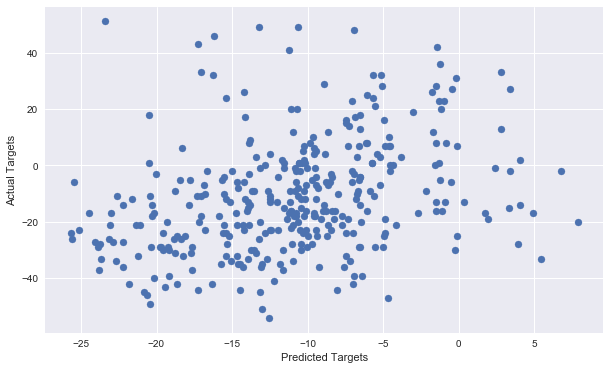

In [494]:
y_twqf = AAL_twqf.iloc[:, 0]
X_twqf = AAL_twqf.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twqf, y_twqf, random_state=23))

### 2. Taxi, Weekday, Hour of Day, Flight Number

In [493]:
AAL_sub_twhf = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
          'f_num'
         ])
           )

AAL_twhf = (pd
            .get_dummies(AAL_sub_twhf, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.110744820297
R-squared (test): 0.106600311835
Adj R-Squared (test): -0.00398336292202
RMSE: 18.9307591021
MAE: 14.5657587099


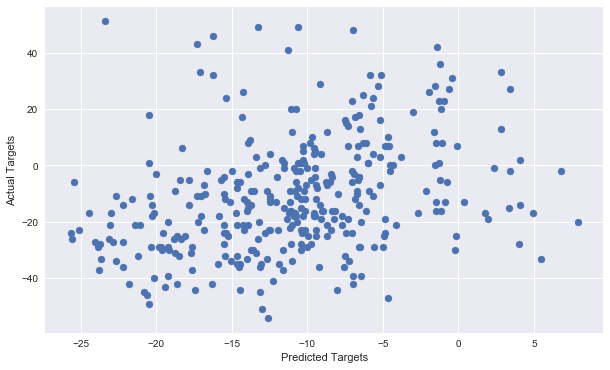

In [497]:
y_twhf = AAL_twhf.iloc[:, 0]
X_twhf = AAL_twhf.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twhf, y_twhf, random_state=23))

This one shows some very strange behavior when certain random states are chosen (try some for kicks). Predicts some very extreme values. FN is probably out.

### 3. Taxi, Weekday, Quarter of Day

In [498]:
AAL_sub_twq = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_twq = (pd
            .get_dummies(AAL_sub_twq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0809094730601
R-squared (test): 0.0912588207494
Adj R-Squared (test): 0.0669175391623
RMSE: 19.0926070777
MAE: 14.6455724976


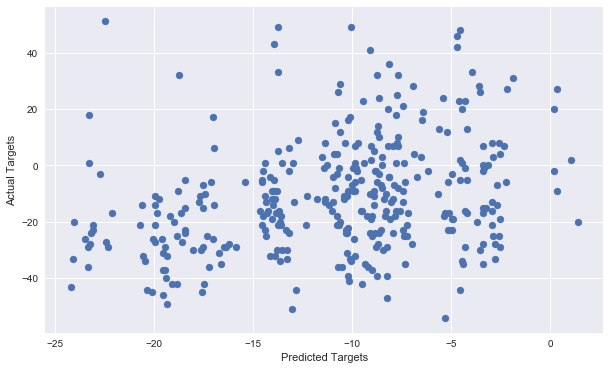

In [500]:
y_twq = AAL_twq.iloc[:, 0]
X_twq = AAL_twq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twq, y_twq, random_state=23))

### 4. Taxi, Weekday, Hour of Day

R-squared (full): 0.110332134371
R-squared (test): 0.110091795233
Adj R-Squared (test): 0.0494788524936
RMSE: 18.8937313663
MAE: 14.5203725945


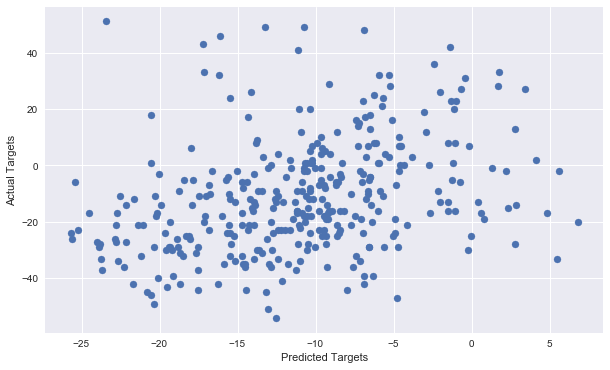

In [501]:
y_twh = AAL_twh.iloc[:, 0]
X_twh = AAL_twh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twh, y_twh, random_state=23))

### 5. Weekday, Quarter of Day

In [502]:
AAL_sub_wq = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_wq = (pd
            .get_dummies(AAL_sub_wq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0714750362129
R-squared (test): 0.0772430952065
Adj R-Squared (test): 0.0553378867841
RMSE: 19.2392785536
MAE: 14.7948494585


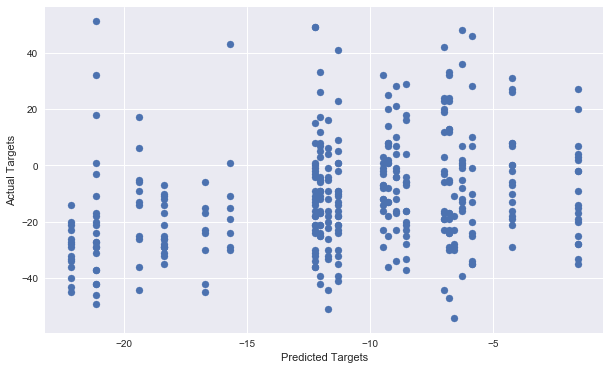

In [504]:
y_wq = AAL_wq.iloc[:, 0]
X_wq = AAL_wq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wq, y_wq, random_state=23))

### 6. Weekday, Hour of Day

In [505]:
AAL_sub_wh = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

AAL_wh = (pd
            .get_dummies(AAL_sub_wh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.101685318744
R-squared (test): 0.0967028462845
Adj R-Squared (test): 0.0381558085437
RMSE: 19.0353318155
MAE: 14.6238294543


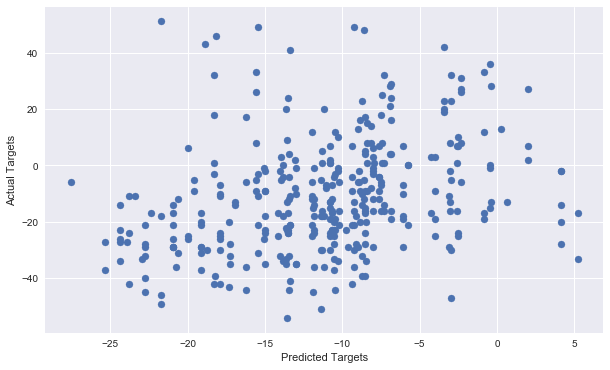

In [506]:
y_wh = AAL_wh.iloc[:, 0]
X_wh = AAL_wh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wh, y_wh, random_state=23))

Because of the trouble that the flight number gave in the final trial above, and the fact that each one is colinear with some hour or quarter of the day, I won't pursue it as a feature. 

Nothing provided particualarly promising scores, but , focusing on day of week and time of day. Will investigate each with and without taxi time.

1. Weekday, Hour of Day, Taxi Time
2. Weekday, Quarter of Day, Taxi Time
3. Weekday, Hour of Day
4. Weekday, Quarter of Day

## Cross-Validation in 10 Minutes

**Abbreviations:**
cvs = cross_val_score()
cvp = cross_val_predict()

In [523]:
def coarse_grid_search(feat_arrs, folds=5):
    """
    Feed list of possible feature arrays (X,y) tuple pais and fold number, 
    spit out RMSE for each fold and the mean RMSE for all.
    """
    
    for n, pair in enumerate(feat_arrs):
        lr = LinearRegression()
        X, y = pair
        nmse_scores = cvs(lr, X, y, cv=folds, scoring='neg_mean_squared_error')
        rmse_scores = [np.sqrt(-1 * i) for i in nmse_scores]
        mean_rmse = sum(rmse_scores) / folds
        
        print("\n*** Model", n+1)
        print(rmse_scores)
        print("Mean RMSE:", mean_rmse)

In [512]:
feature_arrays = [(X_twq, y_twq),
                  (X_twh, y_twh),
                  (X_wq, y_wq),
                  (X_wh, y_wh)
                 ]

In [524]:
coarse_grid_search(feature_arrays, folds=10)


*** Model 1
[22.769720672854049, 21.293563117776465, 23.736190568290759, 17.775545288280124, 20.782026860269458, 21.052546876842936, 18.689881938188261, 16.793187642295745, 13.842088095746005, 17.426664684066811]
Mean RMSE: 19.4161415745

*** Model 2
[21.062988790748264, 20.408941422527295, 23.821284472324592, 17.743707678301359, 23.704015479610074, 21.441002843957229, 18.755072129995881, 16.466003167872373, 13.875074976983642, 17.359437734672685]
Mean RMSE: 19.4637528697

*** Model 3
[23.193734461816852, 21.483667664411264, 23.798116045476817, 18.108922711356183, 20.791626920561981, 20.925497873581012, 19.0384222261888, 16.746731512949118, 13.809573390490289, 17.222669215212314]
Mean RMSE: 19.5118962022

*** Model 4
[21.398217635458781, 20.807237052868995, 23.788355381258455, 17.893389239464611, 23.11133939409314, 21.7012778666912, 19.022306587486867, 16.455623085145326, 13.920860271897572, 17.268449752068594]
Mean RMSE: 19.5367056266


All four feature sets performed about as poorly, though Model 1 (Taxi Time, Weekday, Quarter of Day) performed slightly better than the others, with a mean RMSE of 19.4 minutes. This one also received the best adjusted-R<sup>2</sup> score of 0.067, so we'll go to production with it.

#### Training the holy model...

In [525]:
holy_model = LinearRegression()
holy_model.fit(X_twq, y_twq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And it's now ready to see some wild data.

## Model Meets Validation Set

In [526]:
with open('../data/AAL_clean.pkl', 'rb') as pf: 
    AAL_val = pickle.load(pf)

Boil down to the same format as the training set, pull out features and target:

In [527]:
AAL_val_sub = AAL_val.filter(['lateness_arr', 
                              'taxi_sch', 
                              'weekday', 
                              'hour_of_day', 
                              'q_of_day', 
                              'f_num'
                             ])

AAL_val_twq = (AAL_val_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_val = (pd
            .get_dummies(AAL_val_twq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [529]:
AAL_val.head()

,lateness_arr,taxi_sch,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,q_of_day_2,q_of_day_3
0,-30,15,0,1,0,0,0,0,0,1
1,-26,20,1,0,0,0,0,0,0,1
2,-27,22,0,0,0,0,0,0,0,1
3,6,55,0,0,0,0,1,0,0,1
4,-2,20,0,0,0,1,0,0,0,1


In [530]:
y_val = AAL_val.iloc[:, 0]
X_val = AAL_val.iloc[:, 1:]

### O holy model, PREDICT!!

In [532]:
y_hat = holy_model.predict(X_val)

In [544]:
MSE_val = mean_squared_error(y_val, y_hat)
RMSE_val = np.sqrt(MSE_val)
print("RMSE:", RMSE_val)

RMSE: 19.3135926944


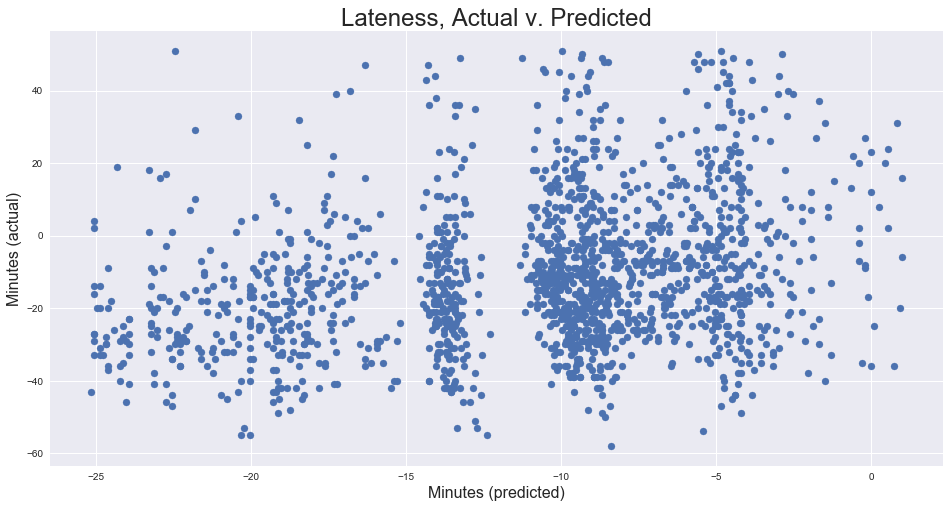

In [539]:
plt.figure(figsize=(16,8))
plt.scatter(y_hat, y_val)
plt.xlabel("Minutes (predicted)", fontsize=16)
plt.ylabel("Minutes (actual)", fontsize=16)
plt.title("Lateness, Actual v. Predicted", fontsize=24);

Not so good...

### Can it at least beat the dummy??

In [540]:
dr = DummyRegressor()

In [541]:
dr.fit(X_twq, y_twq)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [542]:
y_twq.mean()

-10.851273148148149

In [543]:
y_dumdum = dr.predict(X_val)

In [545]:
MSE_dumdum = mean_squared_error(y_val, y_dumdum)
RMSE_dumdum = np.sqrt(MSE_dumdum)
print("RMSE (model):", RMSE_val)
print("RMSE (dummy):", RMSE_dumdum)

RMSE (model): 19.3135926944
RMSE (dummy): 20.1146231079


Beat by 0.8!!